# 3W dataset's General Presentation

This is a general presentation of the 3W dataset, to the best of its authors' knowledge, the first realistic and public dataset with rare undesirable real events in oil wells that can be readily used as a benchmark dataset for development of machine learning techniques related to inherent difficulties of actual data.

For more information about the theory behind this dataset, refer to the paper **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** published in the **Journal of Petroleum Science and Engineering** (link [here](https://doi.org/10.1016/j.petrol.2019.106223)).

# 1. Introduction

This Jupyter Notebook presents the 3W dataset in a general way. For this, some tables, graphs, and statistics are presented.

# 2. Imports and Configurations

In [1]:
import sys
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
#NUM_PARALLEL_EXEC_UNITS = 6
#config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads = NUM_PARALLEL_EXEC_UNITS, 
#         inter_op_parallelism_threads = 1, 
#         allow_soft_placement = True, 
#         device_count = {'CPU': NUM_PARALLEL_EXEC_UNITS })
#session = tf.compat.v1.Session(config=config)
#tf.compat.v1.keras.backend.set_session(session)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow_addons as tfa

from util_3WT import d3w, CustomDataGen

import pickle
import bisect
import sklearn
import sklearn.model_selection
from sklearn.metrics import classification_report

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 3. Instances' Structure

Below, all 3W dataset's instances are loaded and the first one of each knowledge source (real, simulated and hand-drawn) is partially displayed.

In [2]:
dset = d3w('../dataset')

..\dataset\0
..\dataset\1
..\dataset\2
..\dataset\3
..\dataset\4
..\dataset\5
..\dataset\6
..\dataset\7
..\dataset\8


In [3]:
flist0 = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
categories=[[0,1,2,3,4,5,6,7,8,101,102,103,104,105,106,107,108]]

train_df, test_df, val_df = dset.split(real=False, simul=False, drawn=True, test_size=0.2, val_size=0.1)

Instances Train: 14  Test: 4  Validation: 2


Each instance is stored in a CSV file and loaded into a pandas DataFrame. Each observation is stored in a line in the CSV file and loaded as a line in the pandas DataFrame. The first line of each CSV file contains a header with column identifiers. Each column of CSV files stores the following type of information:

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).

Other information are also loaded into each pandas Dataframe:

* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

More information about these variables can be obtained from the following publicly available documents:

* ***Option in Portuguese***: R.E.V. Vargas. Base de dados e benchmarks para prognóstico de anomalias em sistemas de elevação de petróleo. Universidade Federal do Espírito Santo. Doctoral thesis. 2019. https://github.com/ricardovvargas/3w_dataset/raw/master/docs/doctoral_thesis_ricardo_vargas.pdf.
* ***Option in English***: B.G. Carvalho. Evaluating machine learning techniques for detection of flow instability events in offshore oil wells. Universidade Federal do Espírito Santo. Master's degree dissertation. 2021. https://github.com/ricardovvargas/3w_dataset/raw/master/docs/master_degree_dissertation_bruno_carvalho.pdf.

# Preprocessing

The following table shows the amount of instances that compose the 3W dataset, by knowledge source (real, simulated and hand-drawn instances) and by instance label.

In [26]:
class kmodel():
    
    def __init__(self, name, layers_list, features, label, categories, batch_size, seq_length, 
                 train_df, val_df, test_df, tmp_path, reset_ts=False, verbose=1):
        self.features = features
        self.n_features = len(features)
        self.label = label
        self.categories = categories
        self.n_classes = len(*categories)
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.tmp_path = pathlib.Path(tmp_path)
        self.verbose = verbose
        self.history = None
        self.class_rep_val = None
        self.class_rep_test = None
        
        self.train = CustomDataGen(train_df, self.features, self.label, categories, 
                                   self.batch_size, self.seq_length, self.tmp_path)
        self.val = CustomDataGen(val_df, self.features, self.label, categories, 
                                 self.batch_size, self.seq_length, self.tmp_path)
        self.test = CustomDataGen(test_df, self.features, self.label, categories, 
                                  self.batch_size, self.seq_length, self.tmp_path)
        self.full = CustomDataGen(pd.concat([train_df, val_df, test_df], ignore_index=True), 
                                  self.features, self.label, categories, 
                                  self.batch_size, self.seq_length, self.tmp_path)
        
        if reset_ts:
            self.full.reset_ts()

        #print(self.train.__getitem__(0))
        
        input = tf.keras.Input(shape=(self.seq_length, 2*self.n_features), name='input')
        
        for i, layer in enumerate(layers_list):
            config = layer.get_config()
            cloned_layer = type(layer).from_config(config)
            if i == 0:
                output = cloned_layer(input)
            else:
                output = cloned_layer(output)
        
        self.model = tf.keras.Model(input, output, name=name)
        
        for layer in self.model.layers:
            print(self.model.name, layer.name, layer.output_shape)
        print('\n')
        
        if self.verbose > 0:
            print(self.model.summary())
        
        return
    
    
    
    def compile_and_fit(self, max_epochs=20, patience=3, lr=0.001):

        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score',
                                                        patience=patience,
                                                        mode='max')

        checkpoint_filepath = self.tmp_path.joinpath('checkpoint')
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_f1_score',
            mode='max',
            save_best_only=True)

        f1_score = tfa.metrics.F1Score(num_classes=self.n_classes, average='micro', threshold=0.5)

        self.model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                           optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                           metrics=[tf.keras.metrics.CategoricalAccuracy(), 
                                    tf.keras.metrics.Precision(),
                                    tf.keras.metrics.Recall(),
                                    f1_score])

        self.history = self.model.fit(self.train, epochs=max_epochs,
                                      validation_data=self.val,
                                      callbacks=[early_stopping, model_checkpoint_callback])

        self.model.load_weights(checkpoint_filepath)
       
        self.class_rep_val = self.class_rep(self.val)
        
        self.class_rep_test = self.class_rep(self.test)

        self.class_rep_full = self.class_rep(self.full)

        if self.verbose > 0:
            self.plot_fithist('f1_score')
            self.print_class_rep(self.class_rep_val, 'Val Classification Report')
            self.print_class_rep(self.class_rep_test, 'Test Classification Report')
            self.print_class_rep(self.class_rep_full, 'All Data Classification Report')

        return

    # Plot training loss & metric 
    def plot_fithist(self, met):
        N = len(self.history.history['loss'])
        plt.style.use("ggplot")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        fig.suptitle('Training Loss & '+met)

        ax1.plot(np.arange(0, N), self.history.history[met], label="train")
        ax1.plot(np.arange(0, N), self.history.history["val_"+met], label="val")
        ax1.set_title(met)
        ax1.set_xlabel("Epoch #")
        ax1.xaxis.get_major_locator().set_params(integer=True)
        ax1.set_ylabel(met)
        ax1.legend(loc="lower right")

        ax2.plot(np.arange(0, N), self.history.history["loss"], label="train")
        ax2.plot(np.arange(0, N), self.history.history["val_loss"], label="val")
        ax2.set_title("Loss")
        ax2.set_xlabel("Epoch #")
        ax2.xaxis.get_major_locator().set_params(integer=True)
        ax2.set_ylabel("Loss")
        ax2.legend(loc="upper right")

        plt.show()
        return
        
    def save(self):
        filename = self.model.name + '_' +\
            'batch_size_' + str(self.batch_size) + '-' +\
            'seq_length_' + str(self.seq_length) + '-' +\
            str(np.datetime64('now')) + '.h5'
        filename = filename.replace(':', '_')
        self.model.save(filename)
        print('model saved in ' + filename)
        return
    
    def class_rep(self, dset):

        pred = self.model.predict(dset)

        y_pred = [self.categories[0][i] for i in np.argmax(pred, axis=1)]
        y_real = dset.get_y()

        return classification_report(y_real, y_pred, zero_division=0, output_dict=True)
    
    def print_class_rep(self, data_dict, title):
        # extracted from: https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/metrics/_classification.py#L1825
        """Build a text report showing the main classification metrics.
        Read more in the :ref:`User Guide <classification_report>`.
        Parameters
        ----------
        report : string
            Text summary of the precision, recall, F1 score for each class.
            Dictionary returned if output_dict is True. Dictionary has the
            following structure::
                {'label 1': {'precision':0.5,
                             'recall':1.0,
                             'f1-score':0.67,
                             'support':1},
                 'label 2': { ... },
                  ...
                }
            The reported averages include macro average (averaging the unweighted
            mean per label), weighted average (averaging the support-weighted mean
            per label), and sample average (only for multilabel classification).
            Micro average (averaging the total true positives, false negatives and
            false positives) is only shown for multi-label or multi-class
            with a subset of classes, because it corresponds to accuracy otherwise.
            See also :func:`precision_recall_fscore_support` for more details
            on averages.
            Note that in binary classification, recall of the positive class
            is also known as "sensitivity"; recall of the negative class is
            "specificity".
        """

        non_label_keys = ["accuracy", "macro avg", "weighted avg"]
        y_type = "binary"
        digits = 2

        target_names = [
            "%s" % key for key in data_dict.keys() if key not in non_label_keys
        ]

        # labelled micro average
        micro_is_accuracy = (y_type == "multiclass" or y_type == "binary")

        headers = ["precision", "recall", "f1-score", "support"]
        p = [data_dict[l][headers[0]] for l in target_names]
        r = [data_dict[l][headers[1]] for l in target_names]
        f1 = [data_dict[l][headers[2]] for l in target_names]
        s = [data_dict[l][headers[3]] for l in target_names]

        rows = zip(target_names, p, r, f1, s)

        if y_type.startswith("multilabel"):
            average_options = ("micro", "macro", "weighted", "samples")
        else:
            average_options = ("micro", "macro", "weighted")

        longest_last_line_heading = "weighted avg"
        name_width = max(len(cn) for cn in target_names)
        width = max(name_width, len(longest_last_line_heading), digits)
        head_fmt = "{:>{width}s} " + " {:>9}" * len(headers)
        report = head_fmt.format("", *headers, width=width)
        report += "\n\n"
        row_fmt = "{:>{width}s} " + " {:>9.{digits}f}" * 3 + " {:>9}\n"
        for row in rows:
            report += row_fmt.format(*row, width=width, digits=digits)
        report += "\n"

        # compute all applicable averages
        for average in average_options:
            if average.startswith("micro") and micro_is_accuracy:
                line_heading = "accuracy"
            else:
                line_heading = average + " avg"

            if line_heading == "accuracy":
                avg = [data_dict[line_heading], sum(s)]
                row_fmt_accuracy = "{:>{width}s} " + \
                        " {:>9.{digits}}" * 2 + " {:>9.{digits}f}" + \
                        " {:>9}\n"
                report += row_fmt_accuracy.format(line_heading, "", "",
                                                  *avg, width=width,
                                                  digits=digits)
            else:
                avg = list(data_dict[line_heading].values())
                report += row_fmt.format(line_heading, *avg,
                                         width=width, digits=digits)
        print(title)
        print(report)
        
        return


In [18]:
class param_fit():
    def __init__(self, name, layers_list, features, label, categories, batch_sizes, seq_lengths, learning_rates, 
                 train_df, test_df, tmp_path):
        self.name = name 
        self.layers_list = layers_list
        self.features = features
        self.label = label
        self.categories = categories
        self.batch_sizes = batch_sizes
        self.seq_lengths = seq_lengths
        self.learning_rates = learning_rates
        self.train_df = train_df
        self.test_df = test_df
        self.tmp_path = tmp_path
        self.report = dict()
        return
    
    def fit(self, n_splits=5, max_epochs=50, patience=3):
        kf = sklearn.model_selection.StratifiedKFold(n_splits=n_splits)
        
        self.report['batch_size'] = []
        self.report['seq_length'] = []
        self.report['learning_rate'] = []
        self.report['cv_n'] = []
        self.report['class_rep_val'] = []
        self.report['class_rep_test'] = []
        for batch_size in self.batch_sizes:
            breset = True
            for seq_length in self.seq_lengths:
                breset = True
                for learning_rate in self.learning_rates:
                    for i, (train_index, val_index) in enumerate(kf.split(self.train_df, self.train_df['label'])):
                        print('\n', i, batch_size, seq_length, learning_rate,
                              len(train_index), len(val_index), '\n')
                        #tf.keras.backend.clear_session()
                        #tf.compat.v1.reset_default_graph()
                        model = kmodel(self.name, self.layers_list, self.features, self.label, self.categories, 
                                   batch_size, seq_length, 
                                   self.train_df.iloc[train_index].reset_index(drop=True), 
                                   self.train_df.iloc[val_index].reset_index(drop=True), 
                                   self.test_df, 
                                   'D:/datatmp', reset_ts=breset, verbose=0)
                        model.compile_and_fit(max_epochs=max_epochs, patience=patience, lr=learning_rate)
                        breset = False
                        self.report['batch_size'].append(batch_size)
                        self.report['seq_length'].append(seq_length)
                        self.report['learning_rate'].append(learning_rate)
                        self.report['cv_n'].append(i)
                        self.report['class_rep_val'].append(model.class_rep_val)
                        self.report['class_rep_test'].append(model.class_rep_test)
                        
                        #del model
                        #tf.keras.backend.clear_session()
                        #tf.compat.v1.reset_default_graph()                        
                        
        
        rep_df = pd.DataFrame(self.report)
        rep_df['val_accuracy'] = rep_df.class_rep_val.apply(pd.Series)['accuracy']
        rep_df['val_precision'] = rep_df.class_rep_val.apply(pd.Series)['macro avg'].apply(pd.Series)['precision']
        rep_df['val_recall'] = rep_df.class_rep_val.apply(pd.Series)['macro avg'].apply(pd.Series)['recall']
        rep_df['val_f1_score'] = rep_df.class_rep_val.apply(pd.Series)['macro avg'].apply(pd.Series)['f1-score']
        rep_df.drop(['class_rep_val', 'class_rep_test'], axis=1, inplace=True)
        
        fdict = {'val_accuracy': ['mean', 'std'], 'val_precision': ['mean', 'std'],
                 'val_recall': ['mean', 'std'], 'val_f1_score': ['mean', 'std']}
        display(rep_df.groupby(['batch_size', 'seq_length', 'learning_rate']).agg(fdict))        
        
        filename = self.name + '_report_' +\
            str(np.datetime64('now')) + '.pkl'
        filename = filename.replace(':', '_')

        with open(filename, 'wb') as f:
            pickle.dump(self.report, f)



In [25]:
%%time

tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()

linear_layers = [tf.keras.layers.Flatten(name='linear_flat'),
                 tf.keras.layers.LayerNormalization(name='linear_norm'),
                 tf.keras.layers.Dense(units=17, activation='sigmoid', name='linear_dense')]

linear_param_fit = param_fit('linear_param_fit', linear_layers, flist0, 'class', categories, 
                             [32, 64], [15, 30], [0.0001, 0.001], 
                             train_df, test_df, 'D:/datatmp')
linear_param_fit.fit(n_splits=5, max_epochs=50)


 0 32 30 0.0001 7 7 

linear_param_fit input [(None, 30, 16)]
linear_param_fit linear_flat (None, 480)
linear_param_fit linear_norm (None, 480)
linear_param_fit linear_dense (None, 17)
324/324 [==============================] - 59s 181ms/step - loss: 2.7105 - categorical_accuracy: 0.2425 - precision: 0.0821 - recall: 0.6950 - f1_score: 0.1469 - val_loss: 2.8186 - val_categorical_accuracy: 0.3414 - val_precision: 0.0723 - val_recall: 0.6048 - val_f1_score: 0.1291

 1 32 30 0.0001 7 7 

linear_param_fit input [(None, 30, 16)]
linear_param_fit linear_flat (None, 480)
linear_param_fit linear_norm (None, 480)
linear_param_fit linear_dense (None, 17)
862/862 [==============================] - 57s 65ms/step - loss: 2.3465 - categorical_accuracy: 0.3773 - precision_1: 0.0891 - recall_1: 0.7562 - f1_score: 0.1594 - val_loss: 1.7329 - val_categorical_accuracy: 0.5353 - val_precision_1: 0.1160 - val_recall_1: 0.8517 - val_f1_score: 0.2043

 0 32 15 0.0001 7 7 

linear_param_fit input [(None, 15,

val_accuracy           val_precision  \
                                            mean       std          mean   
batch_size seq_length learning_rate                                        
32         15         0.0001            0.327078  0.146872      0.092231   
           30         0.0001            0.438351  0.137042      0.103150   

                                              val_recall            \
                                          std       mean       std   
batch_size seq_length learning_rate                                  
32         15         0.0001         0.011413   0.102334  0.007983   
           30         0.0001         0.011578   0.130324  0.006844   

                                    val_f1_score            
                                            mean       std  
batch_size seq_length learning_rate                         
32         15         0.0001            0.082503  0.019870  
           30         0.0001            0.102197  0.017333

Wall time: 9min 31s


# Linear model

In [7]:
%%time

linear_layers = [tf.keras.layers.Flatten(),
                 tf.keras.layers.LayerNormalization(),
                 tf.keras.layers.Dense(units=17, activation='sigmoid')]

linear_model = kmodel('LinearModel', linear_layers, flist0, 'class', categories, 64, 15, 
                      train_df, val_df, test_df, 'D:/datatmp', reset_ts=True)

linear_model.compile_and_fit(max_epochs=50, patience=5, lr=0.0001)

linear_model.save()

ValueError: Found unexpected instance while processing input tensors for keras functional model. Expecting KerasTensor which is from tf.keras.Input() or output from keras layer call(). Got: <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000028A42ACEB20>>

In [ ]:
v = pd.DataFrame.from_dict(linear_model.class_rep_val)
t = pd.DataFrame.from_dict(linear_model.class_rep_full)
pd.concat((v, t)).mean()

<table><tr>
<td> 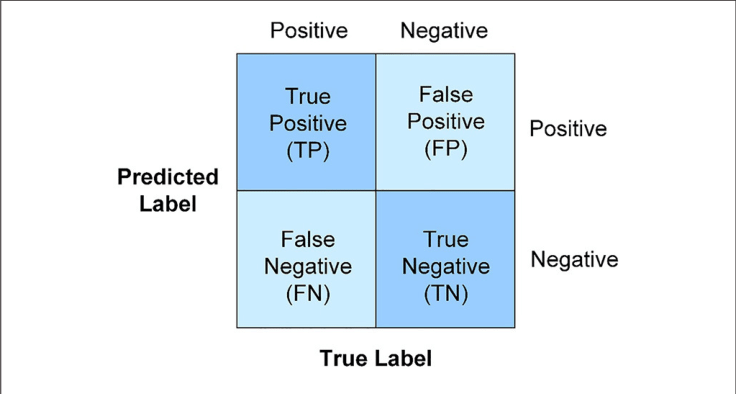 </td>
<td> 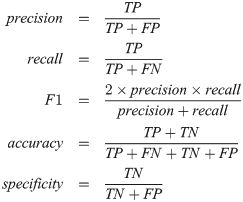 </td>
</tr></table>


# DNN model

In [7]:
%%time

dnn_layers = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.1, seed=200560),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.1, seed=200560),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.1, seed=200560),
    tf.keras.layers.Dense(units=17, activation='relu'),
    tf.keras.layers.Softmax()
]
dnn_model = kmodel('DNNModel', dnn_layers, flist0, 'class', categories, 32, 15, 
                      train_df, val_df, test_df, 'D:/datatmp', reset_ts=False)

dnn_model.compile_and_fit(max_epochs=50, patience=5, lr=0.0001)

dnn_model.save()

ValueError: Found unexpected instance while processing input tensors for keras functional model. Expecting KerasTensor which is from tf.keras.Input() or output from keras layer call(). Got: <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x000002431623EB20>>

# RNN model

In [ ]:
%%time

rnn_layers =[
    tf.keras.layers.LSTM(128, return_sequences=False, dropout=0.15),
    #tf.keras.layers.Dense(units=64, activation='relu'),
    #tf.keras.layers.Dropout(0.2, seed=200560),
    tf.keras.layers.Dense(units=17, activation='relu'),
    tf.keras.layers.Softmax()
]

rnn_model = kmodel('RNNModel', rnn_layers, flist0, 'class', categories, 32, 15, 
                      train_df, val_df, test_df, 'D:/datatmp', reset_ts=False)

rnn_model.compile_and_fit(max_epochs=50, patience=5, lr=0.001)

rnn_model.save()

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())